**Imports**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.signal import find_peaks
from google.colab import drive

drive.mount('/content/drive')
datadir  = '/content/drive/MyDrive/Coursework/Google Colab/OIR MKID Replacement/' #this line is the filepath in my personal google drive
modeldir = '/content/drive/MyDrive/Coursework/Google Colab/OIR MKID Replacement/Attempt Eight/'


Mounted at /content/drive


**Training Metrics**

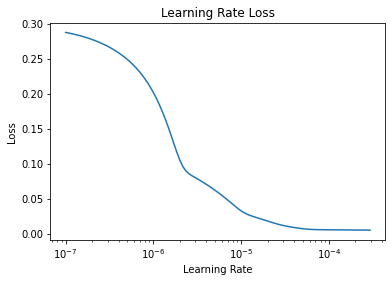

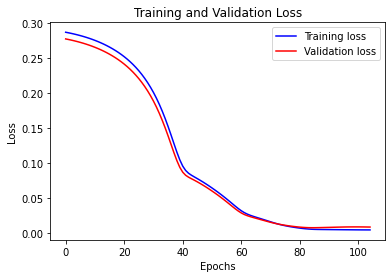

In [5]:
history=np.load(modeldir +'my_history.npy',allow_pickle = True).item()

def visualize_loss(history, title):
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, c="b", label="Training loss")
    plt.plot(epochs, val_loss,c="r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

#display Loss as a function of Learning Rate
plt.semilogx(history["lr"], history["loss"])
plt.xlabel("Learning Rate")
plt.title("Learning Rate Loss")
plt.ylabel("Loss")
plt.show()

#Display Loss as a function of epochs
visualize_loss(history,"Training and Validation Loss")

**IQ Data and Sweep Visualization**

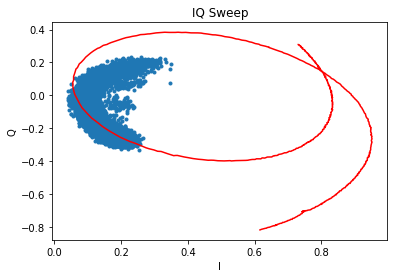

In [6]:
#Loading Sweep Data
sweep = np.load(datadir+'sweep.npz')
f = sweep['f']
z = sweep['z']

#Loading Evaluation Data
data = np.load(datadir+'model_evaluation_data.npz')
I = data['I']
Q = data['Q']
label = data['label']
peaks = data['peaks']
time = data['time']
data = 0 #free up memory

#Raw IQ Data and Sweep visualization
plt.title('IQ Sweep')
plt.plot(-I,Q,linestyle = '',marker='.') #negative I and negative z.real is used to correct phasor diagram to have correct orientation(aesthetics)
plt.plot(-z.real,z.imag, c='red')
plt.xlabel("I")
plt.ylabel('Q')

#Processing Raw Data
def normalize(data):
  #in order to be able to undo normalization at the end, we need fixed values for min/max, which I have overestimated here
  max_val = 0.3
  min_val = -0.6
  return (data-min_val)/(max_val-min_val)

def inv_norm(data):
  max_val = 0.3
  min_val = -0.6
  return data*(max_val-min_val) + min_val

I = normalize(I)
Q = normalize(Q)


evaluation_array = np.zeros(shape=(I.size,3))
evaluation_array[:,0] = time #time data as 0 axis for tf.keras.utils.timeseries_dataset_from_array
evaluation_array[:,1] = I
evaluation_array[:,2] = Q


#These hyperparameters must match those used to train the model so that data is consistent from training to evaluation
sequence_length = 10
step = 1
batch_size = 32 


#evaluation dataset from normalized IQ data
dataset_eval = tf.keras.utils.timeseries_dataset_from_array(
      data = evaluation_array,
      targets = None,
      sequence_length = sequence_length,
      sampling_rate = step,
      batch_size = batch_size,
  )


**Model Compared with Labelled Data** 

In [7]:
model = tf.keras.models.load_model(modeldir + 'my_checkpoint.h5')
output = model.predict(dataset_eval)

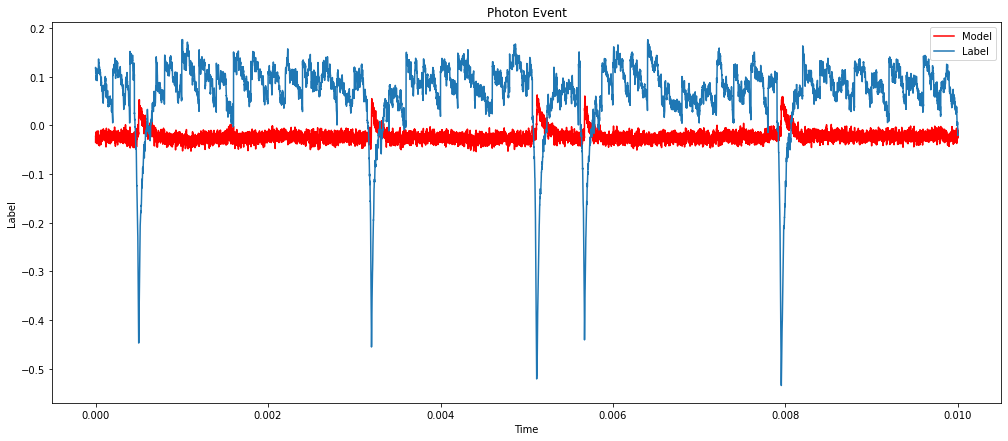

In [8]:
model_prediction = output[:,0,:].ravel() #flattening the 3 dimensional array of values into a 1D array to be used for visualizations
model_prediction = inv_norm(model_prediction) #inverting the normalization on the predictions to recover label predictions


#Photon Event Visualization
plt.figure(figsize = (17,7))
plt.title("Photon Event")
plt.plot(time[0:20000],model_prediction[:20000],label = "Model", c = 'red')
plt.plot(time[0:20000],label[0:20000],label = "Label")
plt.xlabel("Time")
plt.ylabel("Label")
plt.legend()


**Peak Generation and Height Histogram**

In [ ]:
'''
LABEL PEAKS
'''
label_indices = np.where(peaks == 1)
label_heights = label[label_indices]


'''
MODEL PEAKS
'''
peak_indices, min = find_peaks(-1*model_prediction,height = 0.3,distance = 50) #multiplied by negative one to find minima instead of maxima

#find_peaks creates an array with peak_indices and a dictionary with peak_heights as a key
photon_heights = min['peak_heights']

#creating array where peaks = 1 and everything else is 0
model_peaks = np.zeros(len(time)) 
model_peaks[peak_indices] = 1 


'''
Plots and Histograms
'''
#Photon Event Visualization with peaks
plt.title("Photon Event with Labelled Peaks")
plt.plot(time[0:10000],model_prediction[:10000], c = 'red')
plt.plot(time[0:10000],model_peaks[0:10000])
plt.xlabel("Time")
plt.ylabel("Label")
plt.show()

#Predicted Photon Height Histogram
plt.title("Photon Height Histogram")
plt.xlabel("Height")
plt.ylabel("Number of Photons")

bins = int(len(photon_heights)*1.15) #obtains the right number of bins from the number of data points scaled by a prefactor
_ = plt.hist(photon_heights, bins = bins, color= 'red', label = 'Model')

model_bins = int(len(label_heights)*0.95) 
_ = plt.hist(-1*label_heights,bins = model_bins, label = 'Label')
plt.legend()
